In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [ ]:
#Read in data
project_directory = os.path.dirname(os.path.abspath("ising_plot.ipynb"))
data_directory = os.path.join(project_directory, "data")
rel_files = os.listdir(data_directory)
abs_files = [os.path.join(data_directory, rel_file) for rel_file in rel_files]
data_files = [file for file in abs_files if not file.find('EM')==-1]
corr_files = [file for file in abs_files if not file.find('SC')==-1]
datas= []
corrs= []
for file in data_files:
    data = pd.read_csv(file, sep=",", skiprows=[0,1,2])
    datas.append(data)
for file in corr_files: 
    corr = pd.read_csv(file, sep=",", skiprows=[0,1,2])
    corrs.append(corr)

In [47]:
T_c_analytic = 2/np.log(1 + np.sqrt(2))  # Analytic critical temperature for the 2D Ising model

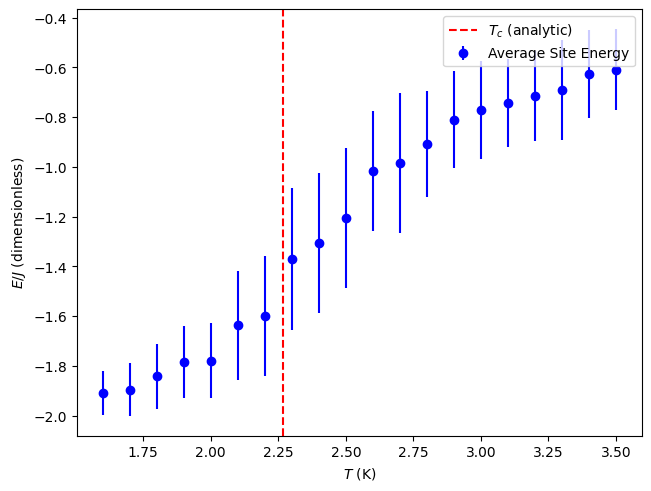

In [51]:
data_first = datas[0]
corr_first = corrs[0]

T, E_mean, E_std, M_mean, M_std, cV_mean, cV_std, Chi_mean, Chi_std = data_first.T.to_numpy() 
fig, ax = plt.subplots(1,1, constrained_layout=True)
ax.errorbar(T, E_mean, yerr=E_std, label='Average Site Energy', fmt='o', color='blue')
ax.set_xlabel('$T$ (K)')
ax.set_ylabel('$E/J$ (dimensionless)')
ax.axvline(x=T_c_analytic, color='red', linestyle='--', label='$T_c$ (analytic)')
ax.legend()